Turning this into an app that people can interact with:

[![Streamlit](https://static.streamlit.io/badges/streamlit_badge_black_white.svg)](https://share.streamlit.io/jimmiemunyi/similarbooks/main/similar_books.py)

In [1]:
#| include: false
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 10.1MB/s 
     |████████████████████████████████| 51kB 6.7MB/s 
     |████████████████████████████████| 1.2MB 55.9MB/s 
     |████████████████████████████████| 194kB 58.7MB/s 
     |████████████████████████████████| 61kB 10.6MB/s 
Mounted at /content/gdrive


In [2]:
#| include: false
from fastbook import *

# Imports

In [3]:
from fastai.collab import *
from fastai.tabular.all import *

# Introduction

We are going to use [Collaborative Filtering](https://en.wikipedia.org/wiki/Collaborative_filtering) to create a book recommendation system. Recommender Systems based on collaborative make recommendations based on what similar users liked. So if I have read Inferno by Dan Brown and liked it (which I did), the system will look for books also liked by people who liked Inferno and recommend them to me.

It uses a concept called *latent factors*. What are latent factors you may ask? Let us understand them using an example.

Let us take two books. Inferno by Dan Brown and To Kill A MockingBird by Harper Lee. Those are two very different books. Let us consider three aspects to classify this books: classics (whether the book is a classic or not), action-oriented and new-gen (modern-times setting).

We will give a score ranging from 1 to -1 to all these three aspects of our books, 1 meaning it scores high on that aspect and -1 for a low score.

So, for example, To Kill a MockingBird is a classic, it is not so much action-oriented and also not so much new-gen. So its scores would look as follows:

In [4]:
mocking_bird = np.array([0.9, -0.85, -0.9])

For Inferno, which is not so much a classic, is action-oriented and is new-gen, we would have the following representation:

In [5]:
inferno = np.array([-0.9, 0.7, 0.9])

Now, let us hypothesize a reader who doesn't enjoy classics that much, doesn't mind action books and really prefers new-gen books (this user actually represents my liking).

In [6]:
reader = np.array([-0.5, 0.2, 0.9])

To see which book we need to recommend our not-so-much hypothetical reader, we will need to perform dot product between the book factors and the user factors. Dot product simply means multiply each consecutive items and add the results.

In [7]:
(reader*mocking_bird).sum()

-1.4300000000000002

In [8]:
(reader*inferno).sum()

1.4

Based on the results, we would want to recommend Inferno to our user and not To Kill A MockingBird since he wouldn't enjoy the latter that much.

The magic part about Collaborative Filtering and the reason we called our factors *latent* is that; we never tell our model anything about what factors to consider or how high or low a book or user scores on each factors. The model learns all that by itself. We simply feed it books rated by users and using that information, it figures out a way to score each factor. As I said, pretty magical.

Let us see that in action.

# The DataSet

Luckily, there is already a good dataset on books and ratings by users called GoodBooks10k available from [this repo in github](https://github.com/zygmuntz/goodbooks-10k). As the name suggests, it contains ratings of 10,000 books and 6 million ratings.

We can download and extract the data using the following convinient functions:

In [9]:
path = Path('data')
if not path.exists():
  path.mkdir()
  untar_data('https://github.com/zygmuntz/goodbooks-10k/releases/download/v1.0/goodbooks-10k.zip', dest=path)

In [10]:
#| include: false
Path.BASE_PATH = path

We can inspect what has been downloaded:

In [11]:
path.ls(file_type='text')

(#5) [Path('README.md'),Path('tags.csv'),Path('books.csv'),Path('book_tags.csv'),Path('ratings.csv')]

We are interested in the rating.csv file, since that is where the actual ratings are. We can load it up in a pandas dataframe:

In [12]:
ratings = pd.read_csv(path/'ratings.csv')

ratings

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3
...,...,...,...
5976474,49925,510,5
5976475,49925,528,4
5976476,49925,722,4
5976477,49925,949,5


We have a `user_id` column that represents each user, `book_id` to represent the books and the `rating` column is the rating given to a book by a particular user. It ranges from 0 to 5.

# Subset of the Dataset

We don't want to work on the full dataset right away since it would take a long time to model and this would limit the number of experiments we can carry out. 

Instead, first we will work with only the first 100, 000 ratings.

In [13]:
ratings = ratings.iloc[:100000]

We check for any missing value and drop them if they exists:

In [14]:
ratings.isnull().values.any()

False

Another issue is with the `book_id`. The model as is would work even if we used `book_id` but for visual purposes, we'd rather have the book title to look at, since that is more informative to us (not the model).

So we will have to load in the books.csv file and merge it with our ratings DataFrame.

In [15]:
books = pd.read_csv(path/'books.csv')

In [16]:
books.columns

Index(['book_id', 'goodreads_book_id', 'best_book_id', 'work_id',
       'books_count', 'isbn', 'isbn13', 'authors', 'original_publication_year',
       'original_title', 'title', 'language_code', 'average_rating',
       'ratings_count', 'work_ratings_count', 'work_text_reviews_count',
       'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5',
       'image_url', 'small_image_url'],
      dtype='object')

We drop some columns which we don't require:

In [17]:
books.drop(['best_book_id', 'work_id', 'title','books_count', 'language_code', 
            'isbn13', 'isbn','ratings_count', 'work_ratings_count', 
            'work_text_reviews_count', 'ratings_1', 'ratings_2', 'ratings_3', 
            'ratings_4', 'ratings_5','image_url', 'small_image_url'], 
           axis=1, inplace=True)

books.head()

,book_id,goodreads_book_id,authors,original_publication_year,original_title,average_rating
0,1,2767052,Suzanne Collins,2008.0,The Hunger Games,4.34
1,2,3,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,4.44
2,3,41865,Stephenie Meyer,2005.0,Twilight,3.57
3,4,2657,Harper Lee,1960.0,To Kill a Mockingbird,4.25
4,5,4671,F. Scott Fitzgerald,1925.0,The Great Gatsby,3.89


Drop any missing values:

In [18]:
books.isnull().values.any()

True

In [19]:
books.dropna(inplace=True)

And finally merge it to one DataFrame:

In [20]:
ratings = ratings.merge(books)

ratings.head()

,user_id,book_id,rating,goodreads_book_id,authors,original_publication_year,original_title,average_rating
0,1,258,5,1232,"Carlos Ruiz Zafón, Lucia Graves",2001.0,La sombra del viento,4.24
1,11,258,3,1232,"Carlos Ruiz Zafón, Lucia Graves",2001.0,La sombra del viento,4.24
2,143,258,4,1232,"Carlos Ruiz Zafón, Lucia Graves",2001.0,La sombra del viento,4.24
3,242,258,5,1232,"Carlos Ruiz Zafón, Lucia Graves",2001.0,La sombra del viento,4.24
4,325,258,4,1232,"Carlos Ruiz Zafón, Lucia Graves",2001.0,La sombra del viento,4.24


## Creating the DataLoaders

Since that looks okay, we can go ahead and create our `DataLoaders` object that we will feed to the model. A `DataLoaders` is simply a convinient object that holds our training and validation data and will pass in the data to our model in mini-batches.

We can look up the documentation of a function by calling the `doc` function.

In [21]:
doc(CollabDataLoaders.from_df)

The above tells us what we will need to pass in the function in order to create our `DataLoaders`. Specifically we will need to pass in :


*   The DataFrame we are creating from (ratings)
*   Size of the Validation split (20%)
*   The column that represents our user (user_id)
*   The column that represents our item (original_title)
*   The column that represents our rating (rating)



In [22]:
dls = CollabDataLoaders.from_df(ratings=ratings, valid_pct=0.2, 
                                user_name='user_id', item_name='original_title',
                                rating_name='rating')

We can look at one batch of data:

In [23]:
dls.show_batch()

,user_id,original_title,rating
0,791,Sphere,3
1,543,Metamorphoses,5
2,1835,1491: New Revelations of the Americas Before Columbus,4
3,2688,"Good Omens: The Nice and Accurate Prophecies of Agnes Nutter, Witch",5
4,264,Jonathan Livingston Seagull,5
5,2074,The Curious Incident of the Dog in the Night-Time,4
6,2136,The Lovely Bones,4
7,1089,Franny and Zooey,5
8,2334,Great Expectations,4
9,750,"The History of the Hobbit, Part One: Mr. Baggins",2


For the latent factors of both our books, we will initialize a random Embedding with a size of all the books we have and the number of factors we want. The same goes for the latent factors of our users.

The values in these Embeddings will be updated by BackPropagation until they become meaningful.

For our small subset of data, we will use 50 factors. This simply means we are giving our model an allowance to represent each books in 50 different ways (e.g. action, classics etc).

So, we first should get the number of users and the number of books:

In [24]:
n_books = len(dls.classes['original_title'])
n_users = len(dls.classes['user_id'])

For learning purposes, we should also get into the habit of manually chekcking shapes of the data in our batches and see if we understand why it is so:

In [25]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 2]), torch.Size([64, 1]))

We are using a batch size of 64, so that makes sense. For our independent variable (X), we have two items there, which are the user and the book and for the dependent variable (y), we only have the rating of the book. That is why the above shapes are so.

## Creating the Model

Next, we need to handle the model part. 

In [26]:
class CollabFiltering(Module):

  def __init__(self, n_users, n_books, n_factors, y_range=(0, 5.5)):
    self.u_weights = Embedding(n_users, n_factors)
    self.u_bias = Embedding(n_users, 1)
    self.i_weights = Embedding(n_books, n_factors)
    self.i_bias = Embedding(n_books, 1)
    self.y_range = y_range
  
  def forward(self, x):
    users = self.u_weights(x[:,0])
    books = self.i_weights(x[:,1])
    res = (users * books).sum(dim=1, keepdims=True)
    res += self.u_bias(x[:,0]) + self.i_bias(x[:,1])
    res = sigmoid_range(res, *self.y_range)
    return res

Our Model Inherits from `Module` which is what PyTorch expects:



```
class CollabFiltering(Module):
```


The model takes in the number of users, the number of books, the number of factors we want to use for modelling and a y_range that defaults to a tuple of (0, 5.5).

The purpose of the y_range is to squish our output between 0 and 5. (We choose 5.5 as the upper limit since we are going to be using sigmoid range to contain our output. And since values in sigmoid never reach the upper limit, to predict a value of 5, we are going to need to go higher).

It then creates the Embeddings of the users and the books. We are also going to create biases for each user and each book to capture the fact that some users generally more positive or negative in their recommendations than others and smoe books are just plain better or worse than others.

```
def __init__(self, n_users, n_books, n_factors, y_range=(0, 5.5)):
    self.u_weights = Embedding(n_users, n_factors)
    self.u_bias = Embedding(n_users, 1)
    self.i_weights = Embedding(n_books, n_factors)
    self.i_bias = Embedding(n_books, 1)
    self.y_range = y_range
```


The forward method simply gets the factors from the user embedding and book embedding, performs dot product on them, adds the biases then uses sigmoid range to squish the output between 0 and 5 and returns the result.


```
def forward(self, x):
    users = self.u_weights(x[:,0])
    books = self.i_weights(x[:,1])
    res = (users * books).sum(dim=1, keepdims=True)
    res += self.u_bias(x[:,0]) + self.i_bias(x[:,1])
    res = sigmoid_range(res, *self.y_range)
    return res
```



We can now instantiate the model with 50 factors and create our Learner. We are going to use Mean Squared Error as our loss function since this is a regression problem.

In [27]:
model = CollabFiltering(n_users, n_books, 50)

In [28]:
learn = Learner(dls, model, loss_func=MSELossFlat())

Let us find a suitable Learning rate and train the model for 6 epochs. We use a weight decay of 0.2 to regularize our model

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=7.585775892948732e-05)

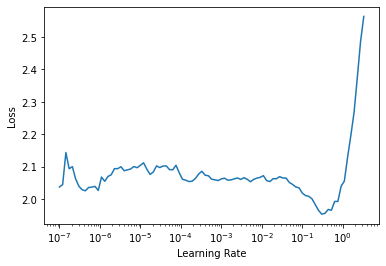

In [29]:
learn.lr_find()

In [30]:
learn.fit_one_cycle(6, 1e-2, wd=0.2)

epoch,train_loss,valid_loss,time
0,0.972651,0.988126,00:08
1,0.959149,0.947992,00:08
2,0.908314,0.913695,00:08
3,0.789891,0.863736,00:08
4,0.646984,0.828928,00:08
5,0.538308,0.826404,00:08


We get a final MSE of 0.826404 which is actually pretty good for out task at hand.

## Interpreting the Embeddings

Let us start by interpretting the book biases. We could have easily ranked the books by the ratings and checked the last five items but bias tells us something more interesting. These books are books that, even if a user was well matched to the latent factors of the book (e.g action, comedy etc), they still didn't like the books and that is why the books have a low bias. In short, they are generally bad books.

These are the 5 books with the lowest bias from our model.

In [31]:
book_bias = learn.model.i_bias.weight.squeeze()
idxs = book_bias.argsort()[:5]
[dls.classes['original_title'][i] for i in idxs]

['Trading Up',
 'One Night @ The Call Center',
 'Four Blondes',
 'Lost',
 'Eat That Frog!: 21 Great Ways to Stop Procrastinating and Get More Done in Less Time']

Since our rating DataFrame included the GoodReads ID of each book, we can create a URL of a single book and check out the reviews from GoodReads.

Let's use Four Blondes as an example. We can locate its entry in our DataFrame using the following code:

In [32]:
books.loc[books['original_title']=='Four Blondes']

,book_id,goodreads_book_id,authors,original_publication_year,original_title,average_rating
4008,4009,6613,Candace Bushnell,2000.0,Four Blondes,2.8


Then using its `goodreads_id`, create a URL that we can follow to read its reviews:

In [33]:
id = 6613
url = f'https://www.goodreads.com/book/show/{id}'
url

'https://www.goodreads.com/book/show/6613'

I haven't read the book myself but I don't think I will too. Reading the reviews from GoodReads looks like people didn't really enjoy this book. Here is one extract of the reviews:



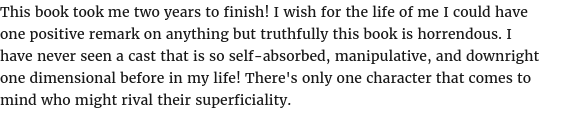

Now let us do the opposite, and check for the books with the highest book bias. This means that these are generally good books and even if you don't enjoy such genres, there is a high chance you will enjoy this books:

In [34]:
idxs = book_bias.argsort(descending=True)[:5]
[dls.classes['original_title'][i] for i in idxs]

['Harry Potter and the Deathly Hallows',
 'A Thousand Splendid Suns',
 'Where the Wild Things Are',
 'Le Petit Prince',
 'دیوان\u200e\u200e [Dīvān]']

At the very top is a book I enjoyed very much myself: Harry Potter and the Deathly Hallows. Since I may be biased towards that book, let us check for reviews of a book I haven't read myself.

In [35]:
id = int(books.loc[books['original_title']=='Le Petit Prince']['goodreads_book_id'].values)
url = f'https://www.goodreads.com/book/show/{id}'
url

'https://www.goodreads.com/book/show/157993'

I was suprised to find that 'Le Petit Prince' or 'The Little Prince' was a child-like novel which adults enjoy as well. Here is one review from GoodReads:

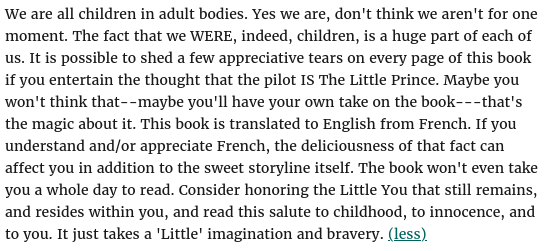



It is definitely on my to-read list now.

Next, let us try and intepret the Book Embedding Factors. Remember, we had 50 factors in our model. Well, intepreting a 50-dimensional Embedding turns out to be a difficult task for us human beings.

Luckily we have a method called `PCA` which stands for Principal Component Analysis that can be used to reduce the dimensions to something that can be plotted in a graph.

Here is the outcome:

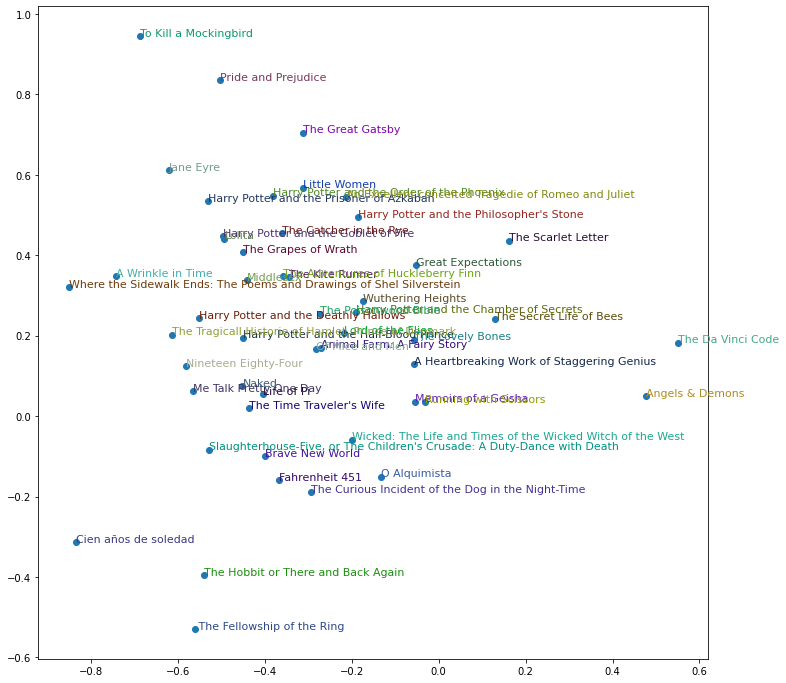

In [36]:
#| fig-cap: "Representation of Books based on two strongest PCA components"

import numpy as np
import matplotlib.pyplot as plt

r = np.arange(0, 2, 0.01)
theta = 2 * np.pi * r
fig, ax = plt.subplots(
  subplot_kw = {'projection': 'polar'} 
)
ax.plot(theta, r)
ax.set_rticks([0.5, 1, 1.5, 2])
ax.grid(True)
plt.show()
```
g = ratings.groupby('original_title')['rating'].count()
top_books = g.sort_values(ascending=False).index.values[:10000]
top_idxs = tensor([learn.dls.classes['original_title'].o2i[m] for m in top_books])
books_w = learn.model.i_weights.weight[top_idxs].cpu().detach()
books_pca = books_w.pca(3)
fac0,fac1,fac2 = books_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_books[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

As you can see, our model has learned for itself to seperate the books into different categories. If you look at the very top, we have the classic books, the likes of *To Kill A MockingBird* and *The Great Gatsby*. At the right side we have the likes of *The Da Vinci Code* and *Angels and Demons* which are more of Mystery Thriller Novels and are more of reality fiction novels. At the bottom we have *The Hobit* books which are more of fantasy novels and Mythology.

What is magical is our model learned all of these on its own! We never explicitely told it what genres a particular book belongs to. We only fed it user ratings and it learned all about them itself.

## Generating Book Reviews

Now comes the interesting part. How to generate a book review for a user. It is actually a very simple concept. The intuition is two similar books should have a smaller distance between them (of the Embeddings) than two different books. So, we will require a reader to input the name of a book he or she enjoyed reading and we will generate a recommendation of books for them.

Let us experiment with 'The Da Vinci Code' by Dan Brown and see the 5 most similar books to it using our model:

In [37]:
book_factors = learn.model.i_weights.weight
idx = dls.classes['original_title'].o2i['The Da Vinci Code']
distances = nn.CosineSimilarity(dim=1)(book_factors, book_factors[idx][None])
idx = distances.argsort(descending=True)[1:6]
[dls.classes['original_title'][i] for i in idx]

['The Sweet Far Thing',
 'Angels & Demons ',
 'Back Roads',
 "What to Expect When You're Expecting",
 'What to Expect the First Year']

According to our model, The Sweet Far Thing is the most similar book, so let us generate a URL and see the reviews:

In [38]:
id = int(books.loc[books['original_title']=='The Sweet Far Thing']['goodreads_book_id'].values)
url = f'https://www.goodreads.com/book/show/{id}'
url

'https://www.goodreads.com/book/show/127459'

The book description describes it as a Thriller novel which was the same case with The Da Vinci Code.

## Neural Network

Now, we will experiment with a Neural Network Model and see if it performs better than our Dot Product Model.



To turn our Model into a Deep Learning Model, we need to concatenate the Embeddings together and pass them through linear layers with non-linearities between them. Our Neural network will have 100 neurons and utilize a ReLU between them. Here is the code:

In [39]:
class CollabFilteringNN(Module):

  def __init__(self, user_sz, book_sz, y_range=(0, 5.5), n_act=100):
    self.user_factors = Embedding(*user_sz)
    self.book_factors = Embedding(*book_sz)
    self.layers = nn.Sequential(
        nn.Linear(user_sz[1]+book_sz[1], n_act),
        nn.ReLU(),
        nn.Linear(n_act, 1)
    )
    self.y_range = y_range
  
  
  def forward(self, x):
    embs = self.user_factors(x[:,0]), self.book_factors(x[:,1])
    x = self.layers(torch.cat(embs, dim=1))
    return sigmoid_range(x, *self.y_range)


We then instantiate the neural network. We will use the `get_emb_sz` to get good Embedding sizes for our users and books. Remember since we will concatenate the Embeddings and not multiply them, they can now have different sizes.

In [40]:
nn_model = CollabFilteringNN(*get_emb_sz(dls))

We can check out our model:

In [41]:
nn_model

CollabFilteringNN(
  (user_factors): Embedding(1795, 106)
  (book_factors): Embedding(4879, 186)
  (layers): Sequential(
    (0): Linear(in_features=292, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=1, bias=True)
  )
)

We will now create our Learner with the same `MSE` loss function, find a suitable learning rate and fit our model for 5 epochs using a regularization weight decay of 0.05:

In [42]:
learn = Learner(dls, nn_model, loss_func=MSELossFlat())

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=3.311311274956097e-06)

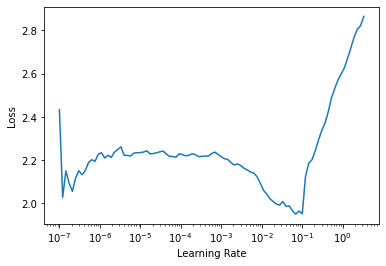

In [43]:
learn.lr_find()

In [45]:
learn = Learner(dls, nn_model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 1e-2, wd=0.05)

epoch,train_loss,valid_loss,time
0,0.775485,0.819169,00:25
1,0.805927,0.817436,00:29
2,0.777418,0.803896,00:30
3,0.716998,0.798450,00:26
4,0.652017,0.812329,00:25


We get roughly the same final MSE.

# Use Full DataSet

Since we are done prototyping and experimenting with the small dataset, it is time to use the full dataset for modelling.

Our full dataset has around 6 million ratings, instead of the 100k we worked with earlier. Therefore it will probably take longer to train. Due to that, we need to train the model for a short number of epochs then save the model's current progress before we continue training.


We will load in the ratings and pre-process the DataSet as before, then create a DataLoaders object and train the model:

In [44]:
ratings = pd.read_csv(path/'ratings.csv')

ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [45]:
ratings = ratings.merge(books)

ratings.head()

,user_id,book_id,rating,goodreads_book_id,authors,original_publication_year,original_title,average_rating
0,1,258,5,1232,"Carlos Ruiz Zafón, Lucia Graves",2001.0,La sombra del viento,4.24
1,11,258,3,1232,"Carlos Ruiz Zafón, Lucia Graves",2001.0,La sombra del viento,4.24
2,143,258,4,1232,"Carlos Ruiz Zafón, Lucia Graves",2001.0,La sombra del viento,4.24
3,242,258,5,1232,"Carlos Ruiz Zafón, Lucia Graves",2001.0,La sombra del viento,4.24
4,325,258,4,1232,"Carlos Ruiz Zafón, Lucia Graves",2001.0,La sombra del viento,4.24


In [46]:
dls = CollabDataLoaders.from_df(ratings=ratings, valid_pct=0.2, 
                                user_name='user_id', item_name='original_title',
                                rating_name='rating')

In [47]:
dls.show_batch()

,user_id,original_title,rating
0,14055,The Crying of Lot 49,3
1,52968,The Gunslinger,5
2,14644,The Five People You Meet in Heaven,4
3,5431,The Gods Themselves,5
4,31889,A Wrinkle in Time,5
5,27179,Jurassic Park,5
6,46433,Watchmen,5
7,43269,The Fault in Our Stars,1
8,39282,"A Return to Love: Reflections on the Principles of ""A Course in Miracles""",5
9,11652,The Mist,3


In [48]:
n_users = len(dls.classes['user_id'])
n_books = len(dls.classes['original_title'])

In [51]:
doc(collab_learner)

We will use the collab_learner provided by fastai for convinience purposes and since I want to export my model after and create an inference app after.

**Note**: It does the exact same thing as our DotProduct Model but has some nice additions on top.

In [52]:
learn = collab_learner(dls, n_factors=500, y_range=(0, 5.5))

SuggestedLRs(lr_min=0.19054607152938843, lr_steep=2.511886486900039e-05)

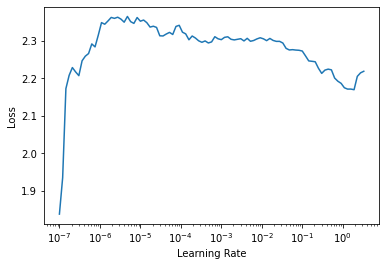

In [53]:
learn.lr_find()

In [54]:
learn.fit_one_cycle(4, 1e-1)

epoch,train_loss,valid_loss,time
0,7.333699,7.176844,24:07
1,7.123693,6.995453,24:09
2,5.130961,5.162658,23:57
3,1.104243,1.095618,24:06


After 4 epochs, we get a MSE of 1.09. This is probably a good time to save the model so we do not lose our progress:

In [55]:
learn.save('4epochs')

Path('models/4epochs.pth')

In [56]:
#| include: false
# If you are using Colab, you can save the model in your Google Drive too
!cp models/4epochs.pth gdrive/MyDrive/Models/Book\ Collab\ Filtering/

We can now load up the model and find continue training it for two more epochs and see if it improves:

In [57]:
learn = learn.load('4epochs')

In [58]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(53425, 500)
  (i_weight): Embedding(9269, 500)
  (u_bias): Embedding(53425, 1)
  (i_bias): Embedding(9269, 1)
)

SuggestedLRs(lr_min=0.002754228748381138, lr_steep=8.31763736641733e-06)

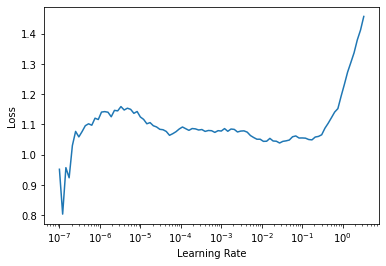

In [59]:
learn.lr_find()

In [60]:
learn.fit_one_cycle(2, 1e-3)

epoch,train_loss,valid_loss,time
0,0.631629,0.749671,24:14
1,0.374357,0.715882,24:15


We go down to an MSE of 0.71 which is even better than what we got with the subset of the dataset.

Since it is taking long to train and I was happy with the results at this point, I stopped after 6 epochs and saved the model. However, if you have time and resources, you can continue training using the same process of saving progress after a few epochs.

In [61]:
learn.save('6epochs')

Path('models/6epochs.pth')

In [62]:
#| include: false
# If you are using Colab, you can save the model in your Google Drive too
!cp models/6epochs.pth gdrive/MyDrive/Models/Book\ Collab\ Filtering/

# Interpreting the Full Model

We can see what our model with the full dataset learned.

We will start with the 5 books with the lowest bias (Generally bad books even if you would like the genre):

In [63]:
book_bias = learn.model.i_bias.weight.squeeze()
idxs = book_bias.argsort()[:5]
[dls.classes['original_title'][i] for i in idxs]

['One Night @ The Call Center',
 'Half Girlfriend',
 'ليتها تقرأ',
 'The 3 Mistakes of My Life',
 'of course i love you']

The book *One Night @ The Call Center* makes another appearance. It must be a really bad book.

Now for the generally good books, the books with the highest book bias:

In [64]:
idxs = book_bias.argsort(descending=True)[:5]
[dls.classes['original_title'][i] for i in idxs]

['The Complete Calvin and Hobbes',
 'Words of Radiance',
 'Complete Harry Potter Boxed Set',
 'The Essential Calvin and Hobbes: A Calvin and Hobbes Treasury',
 'The Calvin and Hobbes Tenth Anniversary Book']

Harry Potter makes another appearance. Let us check out one of the books:

In [65]:
id = int(books.loc[books['original_title']=='Words of Radiance']['goodreads_book_id'].values)
url = f'https://www.goodreads.com/book/show/{id}'
url

'https://www.goodreads.com/book/show/17332218'

Here is a sample review of the book:

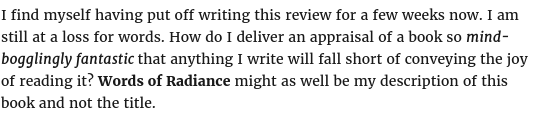

Next we can check out the Book Embeddings using the PCA trick we utilized before:

In [67]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(53425, 500)
  (i_weight): Embedding(9269, 500)
  (u_bias): Embedding(53425, 1)
  (i_bias): Embedding(9269, 1)
)

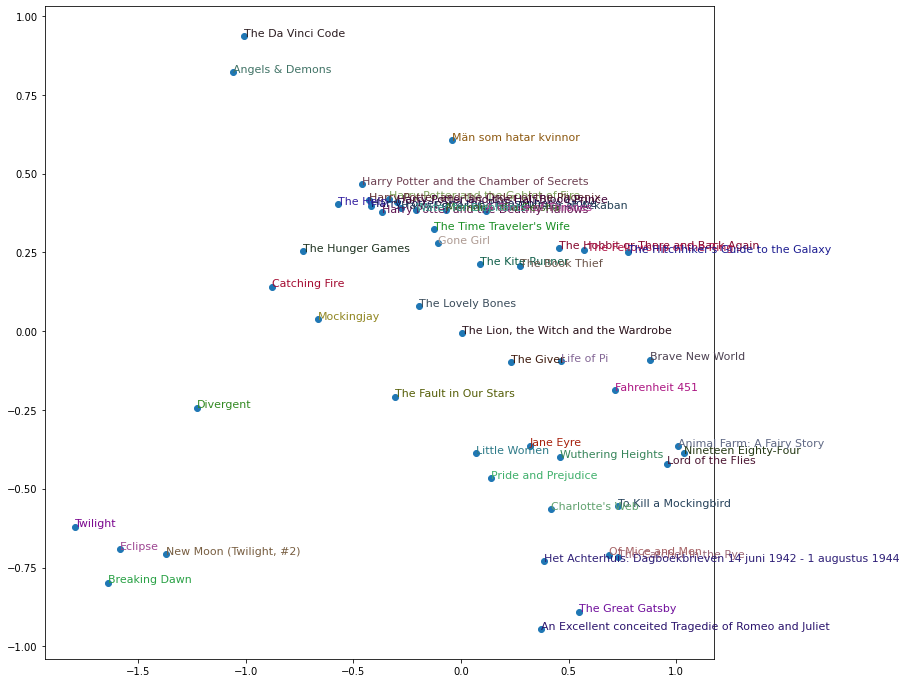

In [71]:
#| fig-cap: "Representation of Books based on two strongest PCA components"
g = ratings.groupby('original_title')['rating'].count()
top_books = g.sort_values(ascending=False).index.values[:10000]
top_idxs = tensor([learn.dls.classes['original_title'].o2i[m] for m in top_books])
books_w = learn.model.i_weight.weight[top_idxs].cpu().detach()
books_pca = books_w.pca(3)
fac0,fac1,fac2 = books_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_books[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

And we can check the distances (similar books). We use The Da Vinci Code again as an example:

In [73]:
book_factors = learn.model.i_weight.weight
idx = dls.classes['original_title'].o2i['The Da Vinci Code']
distances = nn.CosineSimilarity(dim=1)(book_factors, book_factors[idx][None])
idx = distances.argsort(descending=True)[1:6]
# dls.classes['original_title'][idx]
[dls.classes['original_title'][i] for i in idx]

['Angels & Demons ',
 'The Lost Symbol',
 'Deception Point',
 'Digital Fortress',
 'The Firm']

Now that I am happy with my model, I will export it and use it to create a Web App for Recommending Similar Books. That will be in Part 2 of this blog and it is coming soon.

In [74]:
learn.export('final_model.pkl')

In [75]:
#| include: false
#saving my model in Google Drive
!cp final_model.pkl gdrive/MyDrive/Models/Book\ Collab\ Filtering/